In [61]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters
from skimage.transform import resize, rotate
import pandas as pd
import os as os
from src import transform_image
from PIL import Image
from sklearn import decomposition, datasets
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans

In [62]:
#list of ruled and unruled images to check length for imbalanced classes

ruled_dir = "images/Ruled"
unruled_dir = 'images/Unruled'

ruled_images = []
unruled_images = []

for file in os.listdir(ruled_dir):
    ruled_images.append(file)

for file in os.listdir(unruled_dir):
    unruled_images.append(file)

In [63]:
len(ruled_images), len(unruled_images)

(454, 669)

### Question! Ruled images =454, Unruled images = 669 .....Do i need to worry about imbalanced classes? (dont think so due to unsupervised learning??)


## Notes: 

dont need to worry about imbalance until 80/20

In [64]:
#using PIL to open images
file_name = os.path.join(ruled_dir, 'IMG_0003.jpg')
sketch_grey = np.array(Image.open(file_name)) 

In [65]:
print('Type: {}'.format(type(sketch_grey)))
print('Shape: {}'.format(sketch_grey.shape))

Type: <class 'numpy.ndarray'>
Shape: (500, 400)


## Now lets try to find the edges and featurize them...using different filters

First Pass:
1. skimage.filters.sobel_h(image[, mask]) - Find the horizontal edges of an image using the Sobel transform.

2. skimage.filters.sobel_v(image[, mask]) - Find the vertical edges of an image using the Sobel transform.

3. filters.sobel


### Second Pass: try_all_threshold, mulitotsu

4. skimage.filters.rank.bottomhat(image, selem, out=None, mask=None, shift_x=False, shift_y=False)   
    * black top-hat transform is defined dually as the difference between the closing and the input image.

5. skimage.filters.rank.tophat(image, selem, out=None, mask=None, shift_x=False, shift_y=False)

    * white top-hat transform is defined as the difference between the input image and its opening by some structuring element
    * Top-hat transforms are used for various image processing tasks, such as feature extraction, background equalization, image enhancement, and others.

6. skimage.filters.try_all_threshold(image, figsize=(8, 5), verbose=True) 
    * Returns a figure comparing the outputs of different thresholding methods.

7. threshold_multiotsu(image, classes=3, nbins=256)
    * Generate classes-1 threshold values to divide gray levels in image.
    * The threshold values are chosen to maximize the total sum of pairwise variances between the thresholded graylevel classes.
    
### added the mean and the std deviation per row to the feature set - check out graphs in notebook

### 3rd pass:more filters - Scharr edge

8. skimage.filters.scharr(image[, mask, axis, …])

    * Find the edge magnitude using the Scharr transform.

9. skimage.filters.scharr_h(image[, mask])

    * Find the horizontal edges of an image using the Scharr transform.

10. skimage.filters.scharr_v(image[, mask])

    * Find the vertical edges of an image using the Scharr transform.
    
 ### 4th pass: more filters - Roberts cross-edge
 
11. skimage.filters.roberts(image[, mask])

    * Find the edge magnitude using Roberts’ cross operator.

12. skimage.filters.roberts_neg_diag(image[, mask])

    * Find the cross edges of an image using the Roberts’ Cross operator.

13. skimage.filters.roberts_pos_diag(image[, mask])

    * Find the cross edges of an image using Roberts’ cross operator
    
### 5th pass: more filters - Prewitt

14. skimage.filters.prewitt(image[, mask, axis, …])

    * Find the edge magnitude using the Prewitt transform.

15. skimage.filters.prewitt_h(image[, mask])

    * Find the horizontal edges of an image using the Prewitt transform.

16. skimage.filters.prewitt_v(image[, mask])

    * Find the vertical edges of an image using the Prewitt transform.

In [66]:
#create sobel features

sobel_h =filters.sobel_h(sketch_grey)
sobel_v =filters.sobel_v(sketch_grey)
sobel = filters.sobel(sketch_grey)


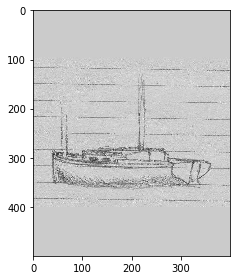

In [67]:
#for presentation
io.imshow(sketch_grey)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


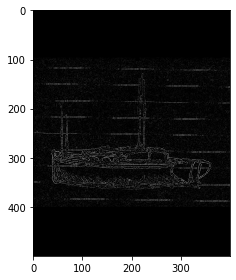

In [68]:
io.imshow(sobel)
io.imsave('images/sample_sobel.png',sobel)

Lossy conversion from float64 to uint8. Range [-0.5274509803921569, 0.4882352941176471]. Convert image to uint8 prior to saving to suppress this warning.


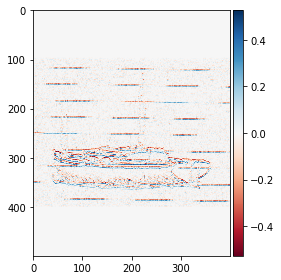

In [69]:
#for presentation
io.imshow(sobel_h);
io.imsave('images/sample_sobel_h.png',sobel_h)

Lossy conversion from float64 to uint8. Range [-0.5284313725490196, 0.4696078431372549]. Convert image to uint8 prior to saving to suppress this warning.


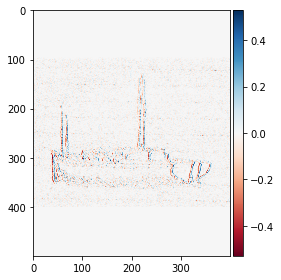

In [70]:
#for presentation
io.imshow(sobel_v);
io.imsave('images/sample_sobel_v.png',sobel_v)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


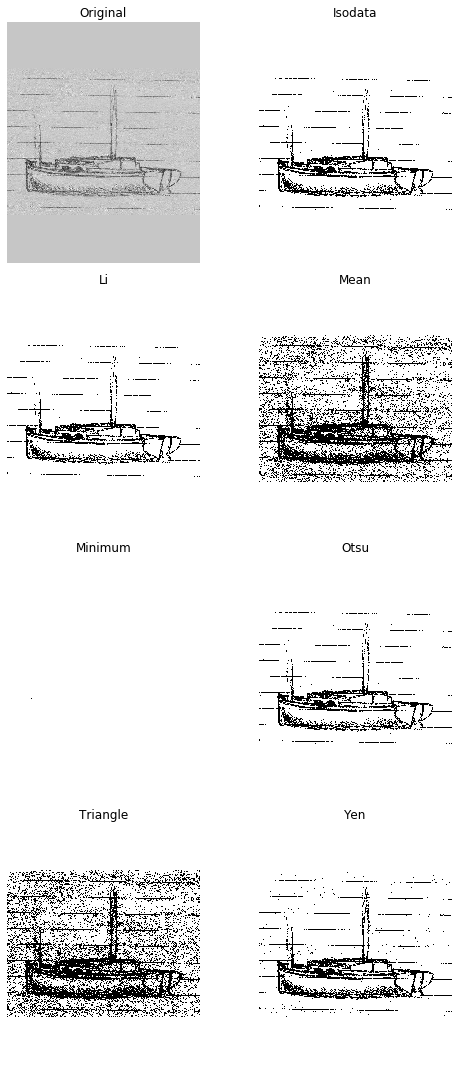

In [71]:
# none of these looked promising as they are threshold filters
filters.try_all_threshold(sketch_grey, figsize=(8, 15), verbose=True); 

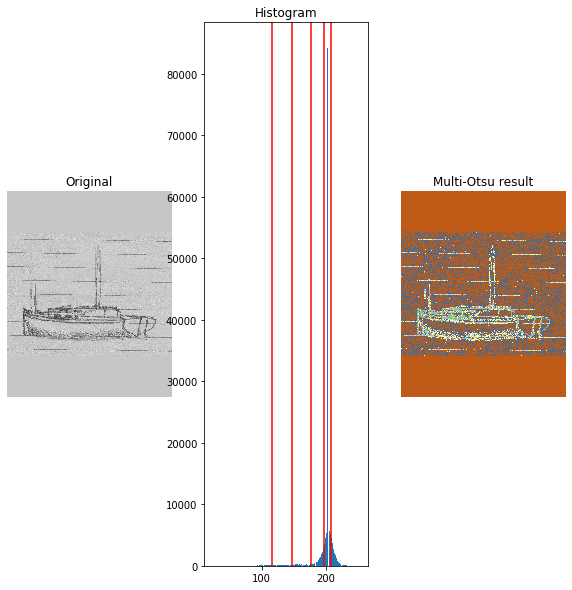

In [72]:
# more filters - ABORTED Tophat/Bottomhat - cant figure out what a selem is? 

# top_hat = filters.rank.tophat(sketch_grey, selem)
# bottom_hat = filters.rank.bottomhat(sketch_grey, selem) 

# 6 seems to best identify the boat and lines the best
thresholds = filters.threshold_multiotsu(sketch_grey, classes=6, nbins=256) #cant get above 6 classes

# Using the threshold values, we generate the three regions.
regions = np.digitize(sketch_grey, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

# Plotting the original image.
ax[0].imshow(sketch_grey, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(sketch_grey.ravel(), bins=256)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='Accent')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

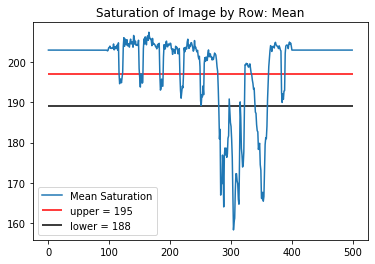

In [73]:
# plot mean of rows
# high values are white, lower the mean of a row the darker the pixels, the 6 spikes below are the 6 background lines 
plt.plot(sketch_grey.mean(axis = 1), label = 'Mean Saturation' ) #across rows
plt.hlines(197, 0, 500, colors='red', linestyles='solid', label='upper = 195')
plt.hlines(189, 0, 500, colors='k', linestyles='solid', label='lower = 188')
plt.title('Saturation of Image by Row: Mean')
plt.legend()

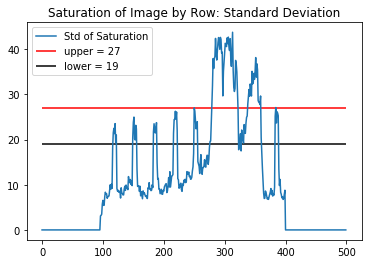

In [74]:
#plot std of rows
plt.plot(np.std(sketch_grey, axis=1), label = 'Std of Saturation')
plt.hlines(27, 0, 500, colors='red', linestyles='solid', label='upper = 27')
plt.hlines(19, 0, 500, colors='k', linestyles='solid', label='lower = 19')
plt.title('Saturation of Image by Row: Standard Deviation')
plt.legend()

In [75]:
#create new DF with std and mean
mean_std_df = pd.DataFrame({'y': range(500), 'mean': sketch_grey.mean(axis = 1), 'std': np.std(sketch_grey, axis =1)})
mean_std_df.head()

,y,mean,std
0,0,203.0,0.0
1,1,203.0,0.0
2,2,203.0,0.0
3,3,203.0,0.0
4,4,203.0,0.0


## Filters 3: add scharr 'edge' filters

(-0.5, 399.5, 499.5, -0.5)

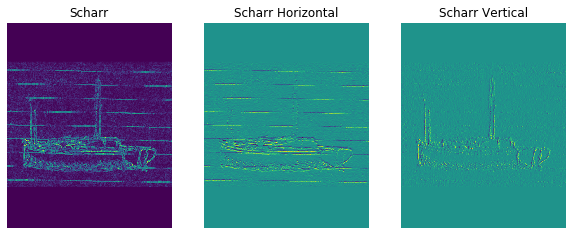

In [76]:
#create scharr filters
scharr = filters.scharr(sketch_grey)
scharr_h = filters.scharr_h(sketch_grey)
scharr_v = filters.scharr_v(sketch_grey)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

ax[0].imshow(scharr)
ax[0].set_title('Scharr')
ax[0].axis('off')

ax[1].imshow(scharr_h)
ax[1].set_title('Scharr Horizontal')
ax[1].axis('off')

ax[2].imshow(scharr_v)
ax[2].set_title('Scharr Vertical')
ax[2].axis('off')


## round 4 add Roberts 'cross edge/diag' filters

(-0.5, 399.5, 499.5, -0.5)

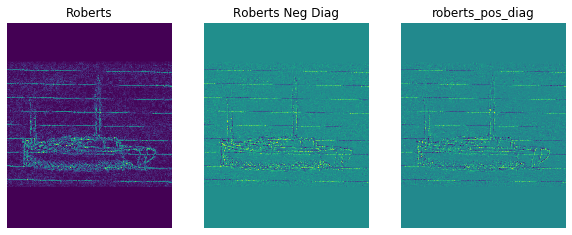

In [77]:
roberts = filters.roberts(sketch_grey)
roberts_neg_diag = filters.roberts_neg_diag(sketch_grey)
roberts_pos_diag = filters.roberts_pos_diag(sketch_grey)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

ax[0].imshow(roberts)
ax[0].set_title('Roberts')
ax[0].axis('off')

ax[1].imshow(roberts_neg_diag)
ax[1].set_title('Roberts Neg Diag')
ax[1].axis('off')

ax[2].imshow(roberts_pos_diag)
ax[2].set_title('roberts_pos_diag')
ax[2].axis('off')



### Prewitt edge filters 

(-0.5, 399.5, 499.5, -0.5)

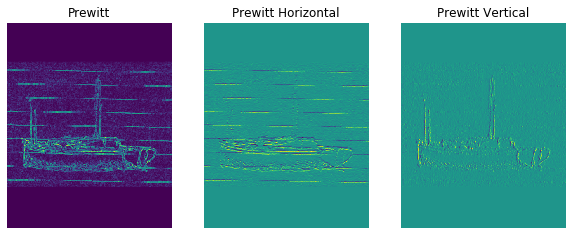

In [78]:
#PREWITT FILTERS -


prewitt = filters.prewitt(sketch_grey)
prewitt_h = filters.prewitt_h(sketch_grey)
prewitt_v = filters.prewitt_v(sketch_grey)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

ax[0].imshow(prewitt)
ax[0].set_title('Prewitt')
ax[0].axis('off')

ax[1].imshow(prewitt_h)
ax[1].set_title('Prewitt Horizontal')
ax[1].axis('off')

ax[2].imshow(prewitt_v)
ax[2].set_title('Prewitt Vertical')
ax[2].axis('off')

In [79]:
#NOW Create a data frame with all of the features for that image
#add regular sobel 
x = []
y = []



for i in range(sketch_grey.shape[0]):
    for j in range(sketch_grey.shape[1]):
        x.append(j)
        y.append(i)
        
        #sobel.append(sobel[i,j])
df = pd.DataFrame({
'x':x, 
'y':y,
'grey':sketch_grey.flatten(),
'sobel':sobel.flatten(),
'sobel_h': sobel_h.flatten(),
'sobel_v': sobel_v.flatten(),
'multiotsu': regions.flatten(),
'scharr': scharr.flatten(),
'scharr_h': scharr_h.flatten(),
'scharr_v': scharr_v.flatten(), 
'roberts': roberts.flatten(),
'roberts_neg_diag': roberts_neg_diag.flatten(),
'roberts_pos_diag': roberts_pos_diag.flatten(),
'prewitt': prewitt.flatten(),
'prewitt_h': prewitt_h.flatten(),
'prewitt_v': prewitt_v.flatten()
}
)
df



,x,y,grey,sobel,sobel_h,sobel_v,multiotsu,scharr,scharr_h,scharr_v,roberts,roberts_neg_diag,roberts_pos_diag,prewitt,prewitt_h,prewitt_v
0,0,0,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,395,499,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199996,396,499,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199997,397,499,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199998,398,499,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
#merge
df = df.set_index('y').join(mean_std_df.set_index('y')).reset_index()

In [81]:
#new idea for feature! If you have a dark pixel on a line thats mostly dark..probably a line, opposite = boat?
df['delta'] = df['grey'] - df['mean']
df['delta'].nunique()

17261

In [82]:
df.head()

,y,x,grey,sobel,sobel_h,sobel_v,multiotsu,scharr,scharr_h,scharr_v,roberts,roberts_neg_diag,roberts_pos_diag,prewitt,prewitt_h,prewitt_v,mean,std,delta
0,0,0,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0
1,0,1,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0
2,0,2,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0
3,0,3,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0
4,0,4,203,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0


In [94]:
#PCA to remove features and to standardize
#pca = PCA(whiten=True).fit_transform(df[['grey', 'sobel', 'sobel_h', 'sobel_v', 'multiotsu', 'mean', 'std', 'delta','scharr','scharr_h','scharr_v']])

# later switched to Standard Scaler...ask Land why??
from sklearn.preprocessing import StandardScaler as SS

ss = SS().fit_transform(df[['grey', 'sobel', 'sobel_h', 'sobel_v', 'multiotsu', 'mean', 'std', 
                            'delta','scharr','scharr_h','scharr_v','roberts','roberts_neg_diag',
                            'roberts_pos_diag']])
ss_df = pd.DataFrame(ss)
ss_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.216195,-0.613541,2.586073e-16,-0.0003,0.125032,0.43024,-0.886368,-3.319650e-18,-0.623108,-2.202749e-16,-0.000281,-0.630398,0.000136,-0.00014
1,0.216195,-0.613541,2.586073e-16,-0.0003,0.125032,0.43024,-0.886368,-3.319650e-18,-0.623108,-2.202749e-16,-0.000281,-0.630398,0.000136,-0.00014
2,0.216195,-0.613541,2.586073e-16,-0.0003,0.125032,0.43024,-0.886368,-3.319650e-18,-0.623108,-2.202749e-16,-0.000281,-0.630398,0.000136,-0.00014
3,0.216195,-0.613541,2.586073e-16,-0.0003,0.125032,0.43024,-0.886368,-3.319650e-18,-0.623108,-2.202749e-16,-0.000281,-0.630398,0.000136,-0.00014
4,0.216195,-0.613541,2.586073e-16,-0.0003,0.125032,0.43024,-0.886368,-3.319650e-18,-0.623108,-2.202749e-16,-0.000281,-0.630398,0.000136,-0.00014


In [84]:
#pca.shape
ss.shape

(200000, 14)

In [117]:
# clustering into groups using KMeans

n = 3
cluster = KMeans(n_clusters=n).fit(ss)
df['labels'] = cluster.labels_


/Users/megan/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


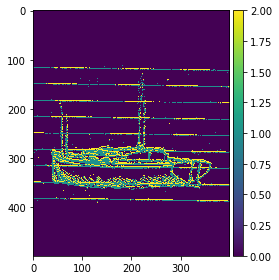

In [118]:
#full image with all clusters

io.imshow(df['labels'].values.reshape(sketch_grey.shape))

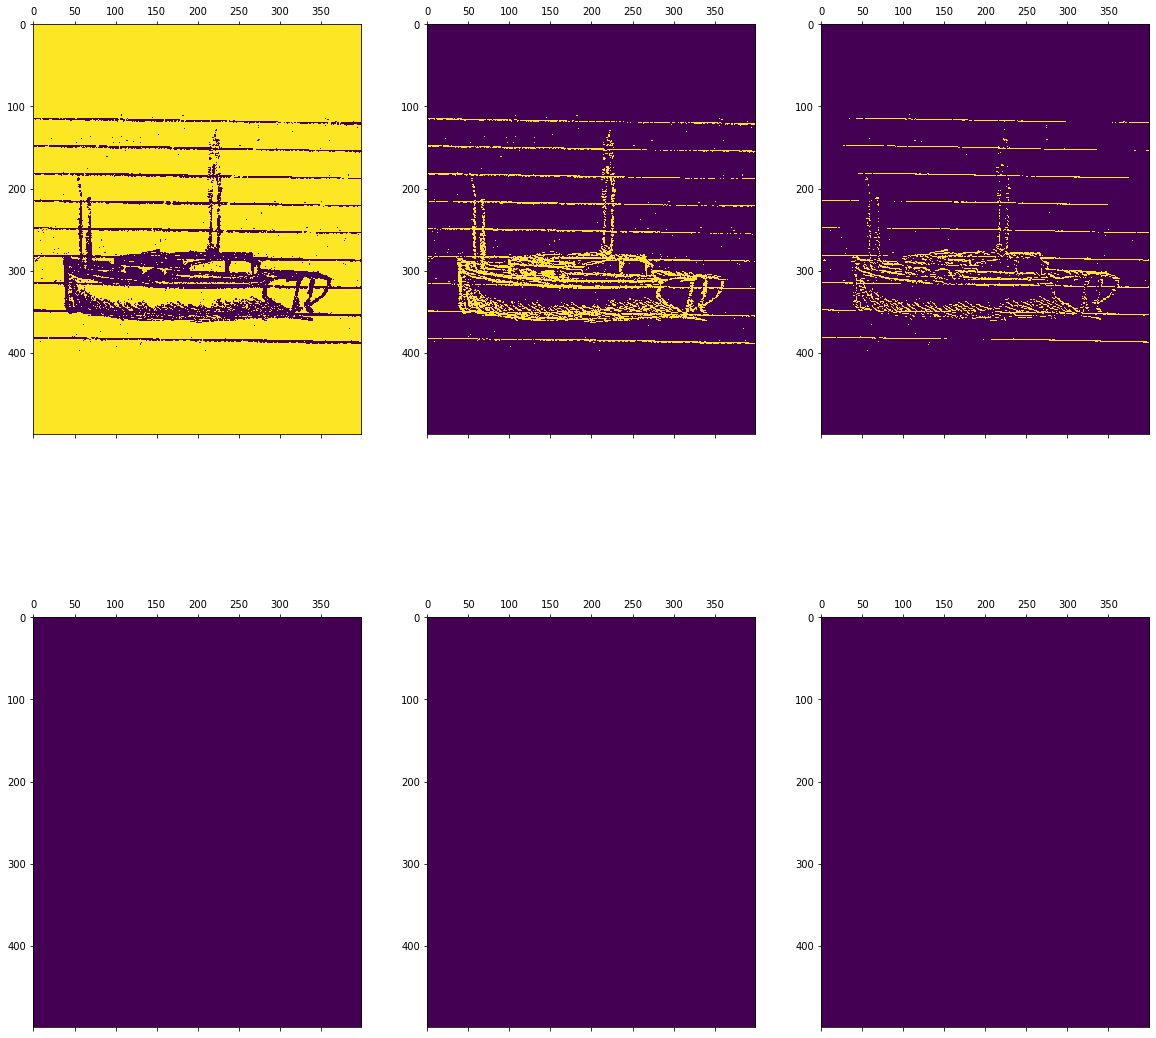

In [119]:
#Images by cluster layers

#io.imshow(df['labels'].values.reshape(sketch_grey.shape))
#plt.matshow(df['labels'].values.reshape(sketch_grey.shape))
fig, axs = plt.subplots(2, 3, figsize=(20,20))

for i, ax in enumerate(axs.flatten()):
    ax.matshow((df['labels']==i).values.reshape(sketch_grey.shape))
    




In [120]:
#the one with the highest first value will be the background - fill in the background lines with NMF
np.set_printoptions(suppress=True) #suppress scientific notation

cluster_centers = cluster.cluster_centers_
cluster_centers

array([[ 0.25422212, -0.27694116,  0.02397646,  0.003505  ,  0.23874452,
         0.22162443, -0.21080863,  0.16523217, -0.27673498,  0.0232884 ,
         0.00328067, -0.2726314 , -0.00310312, -0.02317365],
       [-2.49125598,  1.78118844,  1.3219963 , -0.46032193, -2.29990038,
        -1.70365295,  1.5997876 , -1.89129547,  1.79187881,  1.31920211,
        -0.48517397,  1.84000429,  1.42213538,  1.37710018],
       [-0.95242849,  2.6326129 , -2.75246221,  0.71535205, -0.96230582,
        -1.63093206,  1.58677827, -0.1537013 ,  2.61010308, -2.7335748 ,
         0.76245286,  2.44365633, -2.36844432, -1.87987753]])

##  NMF
The plan:
1. identify background layer - highest grey value or lightest color
2. apply NMF to reconstruct the full image - turning the whole thing white or solid
3. add the boat 

### isolate cluster layers

In [121]:
#Determine the background cluster (the one with the most pixels)¶
background_cluster = np.argmax(df.groupby('labels').count().values[:,0])
background_cluster


0

Determine the cluster that contains the boat. I'm going to assume that the boat is drawn near the center of the image, so this is going to be the cluster that has the lowest standard deviation of y values.

In [122]:
boat_cluster = df[['labels','y']].groupby('labels').std().idxmin()[0]
boat_cluster

1

Make a new, empty image with values set to the average grey value of the background cluster

In [123]:
new_image = np.zeros(shape = sketch_grey.shape)
new_image += df[['labels','grey']].groupby('labels').mean().loc[background_cluster]
#new_image += df[['labels','grey']].groupby('labels').mean().loc[2]
new_image

array([[203.72315722, 203.72315722, 203.72315722, ..., 203.72315722,
        203.72315722, 203.72315722],
       [203.72315722, 203.72315722, 203.72315722, ..., 203.72315722,
        203.72315722, 203.72315722],
       [203.72315722, 203.72315722, 203.72315722, ..., 203.72315722,
        203.72315722, 203.72315722],
       ...,
       [203.72315722, 203.72315722, 203.72315722, ..., 203.72315722,
        203.72315722, 203.72315722],
       [203.72315722, 203.72315722, 203.72315722, ..., 203.72315722,
        203.72315722, 203.72315722],
       [203.72315722, 203.72315722, 203.72315722, ..., 203.72315722,
        203.72315722, 203.72315722]])

Copy background values from df into new image

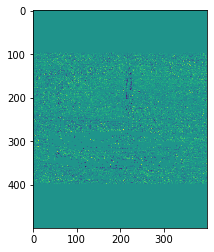

In [124]:
for _, row in df[df['labels']==background_cluster].iterrows():
#for _, row in df[df['labels']==2].iterrows():
    new_image[int(row['y']),int(row['x'])] = row['grey']

plt.imshow(new_image)

Use NMF to deconstruct the image into H and W matrices:

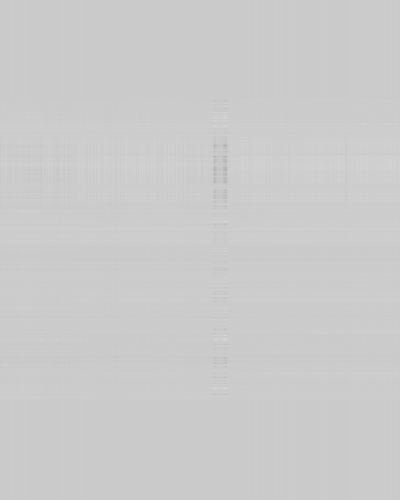

In [125]:
#nmf = NMF(n_components = 4, max_iter=10000, tol = .001 )
nmf = NMF(n_components = 2, max_iter=10000, tol = .001 )
H = nmf.fit_transform(new_image)
W = nmf.components_

#combine Hand W to make new image

new_image = H@W
Image.fromarray(new_image.astype(np.uint8))

Copy the boat to the new image

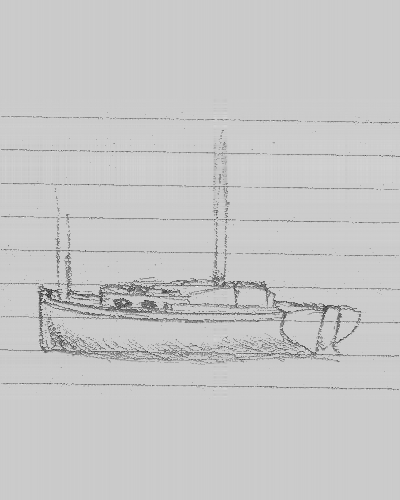

In [126]:
for _, row in df[df['labels']==boat_cluster].iterrows():
    new_image[int(row['y']),int(row['x'])] = row['grey']
    
new_image = new_image.astype(np.uint8)
Image.fromarray(new_image)
    

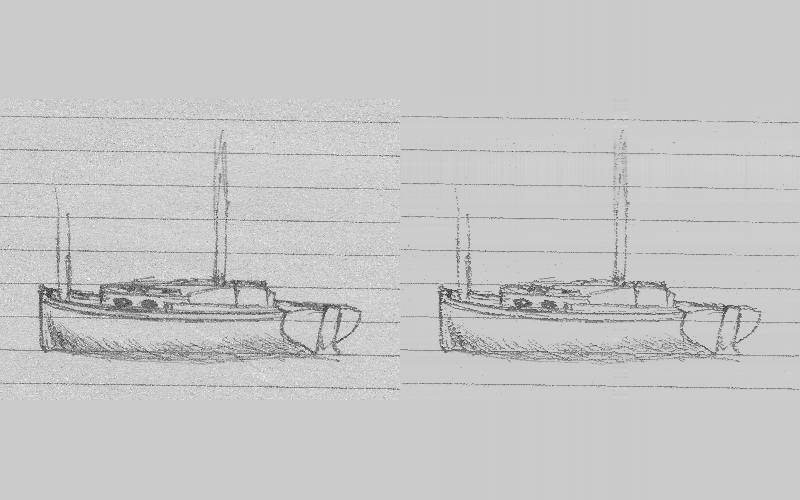

In [127]:
#compare original to final


Image.fromarray(np.hstack([sketch_grey, new_image]))

In [ ]:
# background_mask = df[df['labels']==0]
# background_grey = df[df['grey']==background_mask]

# nmf = NMF(n_components=2,init=None, solver='cd', beta_loss='frobenius',
#             tol=0.0001, max_iter=200, alpha=0.0, l1_ratio=0.0, verbose=10)

# nmf.fit(background)
# W = nmf.transform(background)
# H = nmf.components_



## What if we just replaced the mean saturation values from the horizontal lines with mean background color?

In [49]:
# another new idea for feature 188-195 is the mean saturation for a row
# mean_saturation = np.arange(188, 196, 1)
#df['mean sat lines'] = df[df['mean'] > 188 and df['mean'] < 195]
df['grey'].loc[30000]

203.0

In [43]:
for target_saturation in range(188,196):
    for mean, idx in enumerate(df['mean']):
        if target_saturation == mean:
            #df[grey] = 203.35348855 #did this work?
            df['grey'].loc[idx] = 203.35348855 #if not try this
            

df            #replace df[grey]at same row with color of background 

/Users/megan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,y,x,grey,sobel,sobel_h,sobel_v,multiotsu,scharr,scharr_h,scharr_v,roberts,roberts_neg_diag,roberts_pos_diag,prewitt,prewitt_h,prewitt_v,mean,std,delta,labels
0,0,0,203.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0,3
1,0,1,203.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0,3
2,0,2,203.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0,3
3,0,3,203.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0,3
4,0,4,203.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499,395,203.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0,3
199996,499,396,203.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0,3
199997,499,397,203.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0,3
199998,499,398,203.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0,3


In [44]:
df['grey'].unique()

array([203.        , 203.35348855, 207.        , 206.        ,
       205.        , 201.        , 198.        , 202.        ,
       200.        , 208.        , 210.        , 204.        ,
       209.        , 199.        , 189.        , 197.        ,
       211.        , 195.        , 194.        , 196.        ,
       213.        , 192.        , 214.        , 212.        ,
       193.        , 216.        , 191.        , 190.        ,
       218.        , 215.        , 217.        , 188.        ,
       219.        , 224.        , 180.        , 222.        ,
       184.        , 220.        , 186.        , 182.        ,
       183.        , 234.        , 169.        , 221.        ,
       226.        , 185.        , 187.        , 229.        ,
       231.        , 174.        , 179.        , 172.        ,
       181.        , 223.        , 232.        , 227.        ,
       225.        , 178.        , 230.        , 173.        ,
       228.        , 237.        , 176.        , 235.  

In [45]:
df[df['grey']==190]

,y,x,grey,sobel,sobel_h,sobel_v,multiotsu,scharr,scharr_h,scharr_v,roberts,roberts_neg_diag,roberts_pos_diag,prewitt,prewitt_h,prewitt_v,mean,std,delta,labels
39641,99,41,190.0,0.052613,-0.070588,0.023529,3,0.053957,-0.071569,0.026471,0.041687,-0.058824,0.003922,0.050913,-0.069281,0.019608,203.5775,5.703419,-13.5775,3
39781,99,181,190.0,0.038586,0.016667,0.051961,3,0.051410,0.018382,0.070343,0.027730,-0.023529,0.031373,0.021912,0.014379,0.027451,203.5775,5.703419,-13.5775,3
40075,100,75,190.0,0.012745,0.016667,-0.006863,3,0.013728,0.013480,-0.013971,0.037716,0.031373,0.043137,0.014904,0.020915,0.002614,203.6400,6.545258,-13.6400,3
40142,100,142,190.0,0.016695,-0.017647,0.015686,3,0.015948,-0.015196,0.016667,0.039216,-0.039216,0.039216,0.017947,-0.020915,0.014379,203.6400,6.545258,-13.6400,3
40177,100,177,190.0,0.010784,-0.010784,0.010784,3,0.022593,-0.009069,0.030637,0.053267,-0.058824,0.047059,0.014438,-0.013072,-0.015686,203.6400,6.545258,-13.6400,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159222,398,22,190.0,0.030956,-0.036275,-0.024510,3,0.032461,-0.038971,-0.024265,0.056080,-0.078431,0.011765,0.029024,-0.032680,-0.024837,204.7275,7.844313,-14.7275,3
159549,398,349,190.0,0.041153,0.031373,0.049020,3,0.044784,0.038235,0.050490,0.087557,-0.023529,0.121569,0.036799,0.022222,0.047059,204.7275,7.844313,-14.7275,3
159733,399,133,190.0,0.018315,0.012745,0.022549,3,0.018132,0.013480,0.021814,0.038623,0.019608,0.050980,0.018602,0.011765,0.023529,203.9900,8.788339,-13.9900,3
159852,399,252,190.0,0.018858,-0.007843,-0.025490,3,0.026144,-0.003922,-0.036765,0.036996,0.011765,0.050980,0.011837,-0.013072,-0.010458,203.9900,8.788339,-13.9900,3


## Aborted DBscan - couldnt get it to run on computer 

In [ ]:
# use DBscan - Skylars suggestion
from sklearn.cluster import DBSCAN
from sklearn import metrics


In [ ]:
#cant get DB scan to work going to try reachability plot
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

In [ ]:
# clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

# X = df[['x','y','grey']]
# # Run the fit
# clust.fit(X)

# labels_35000 = cluster_optics_dbscan(reachability=clust.reachability_,
#                                    core_distances=clust.core_distances_,
#                                    ordering=clust.ordering_, eps=350)
# labels_20000 = cluster_optics_dbscan(reachability=clust.reachability_,
#                                    core_distances=clust.core_distances_,
#                                    ordering=clust.ordering_, eps=200)

# space = np.arange(len(X))
# reachability = clust.reachability_[clust.ordering_]
# labels = clust.labels_[clust.ordering_]

# plt.figure(figsize=(10, 7))
# G = gridspec.GridSpec(2, 3)
# ax1 = plt.subplot(G[0, :])
# ax2 = plt.subplot(G[1, 0])
# ax3 = plt.subplot(G[1, 1])
# ax4 = plt.subplot(G[1, 2])

# # Reachability plot
# colors = ['g.', 'r.', 'b.', 'y.', 'c.']
# for klass, color in zip(range(0, 5), colors):
#     Xk = space[labels == klass]
#     Rk = reachability[labels == klass]
#     ax1.plot(Xk, Rk, color, alpha=0.3)
# ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
# ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
# ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
# ax1.set_ylabel('Reachability (epsilon distance)')
# ax1.set_title('Reachability Plot')

# # OPTICS
# colors = ['g.', 'r.', 'b.', 'y.', 'c.']
# for klass, color in zip(range(0, 5), colors):
#     Xk = X[clust.labels_ == klass]
#     ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
# ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
# ax2.set_title('Automatic Clustering\nOPTICS')

# # DBSCAN at 350
# colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
# for klass, color in zip(range(0, 6), colors):
#     Xk = X[labels_35000 == klass]
#     ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
# ax3.plot(X[labels_35000 == -1, 0], X[labels_35000 == -1, 1], 'k+', alpha=0.1)
# ax3.set_title('Clustering at 350 epsilon cut\nDBSCAN')

# # DBSCAN at 200.
# colors = ['g.', 'm.', 'y.', 'c.']
# for klass, color in zip(range(0, 4), colors):
#     Xk = X[labels_20000 == klass]
#     ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
# ax4.plot(X[labels_20000 == -1, 0], X[labels_20000 == -1, 1], 'k+', alpha=0.1)
# ax4.set_title('Clustering at 200.0 epsilon cut\nDBSCAN')

# plt.tight_layout()
# plt.show()


In [ ]:
X = df[['x','y','grey', 'sobel_h',  'mean', 'std', 'delta']]
X = SS().fit_transform(X)


In [ ]:
#precomputing the distances so it takes less time to do dbscan (randomly assigned 1.5 as radius!!)
from sklearn.neighbors import radius_neighbors_graph
X1 = radius_neighbors_graph(X, radius=1, mode='distance')
X1

In [ ]:
# Compute DBSCAN - eps tried .5, .7, .3, 2, .1, 300,  all give 1 cluster
dbscan = DBSCAN(eps=10,metric='precomputed', min_samples=5).fit(X1)
# core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
# core_samples_mask[dbscan.core_sample_indices_] = True
db_labels = dbscan.labels_


In [ ]:
#core_samples_mask

In [ ]:
len(np.unique(db_labels))

In [ ]:
#db_labels = labels

In [ ]:
# Number of clusters in labels, ignoring noise if present.

# n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
# n_noise_ = list(db_labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)
# #print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# #print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# #print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# #print("Adjusted Rand Index: %0.3f"
#       #% metrics.adjusted_rand_score(labels_true, labels))
# #print("Adjusted Mutual Information: %0.3f"
#       #% metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X1, db_labels))

# # #############################################################################
# # Plot result
# import matplotlib.pyplot as plt

# # Black removed and is used for noise instead.
# unique_labels = set(db_labels)
# colors = [plt.cm.Spectral(each)
#           for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = (db_labels == k)

#     xy = X1[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)

#     xy = X1[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

In [ ]:
#add db_labels to df

df['db_labels'] = dbscan.labels_
df.groupby('db_labels').count()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20,20))

for i, ax in enumerate(axs.flatten()):
    ax.matshow((df['db_labels']==i-1).values.reshape(sketch_grey.shape))
    

## extra code that might be useful later below this line

In [ ]:
# exp_var_ratio = pca.explained_variance_ratio_
# exp_sing_vals = pca.singular_values_

#df['labels'].nunique()

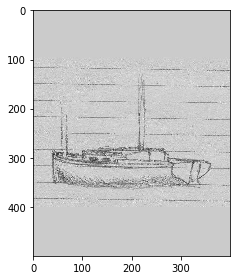

In [35]:
#turn back into an image

new_image = df['grey'].values.reshape(sketch_grey.shape)
io.imshow(new_image)

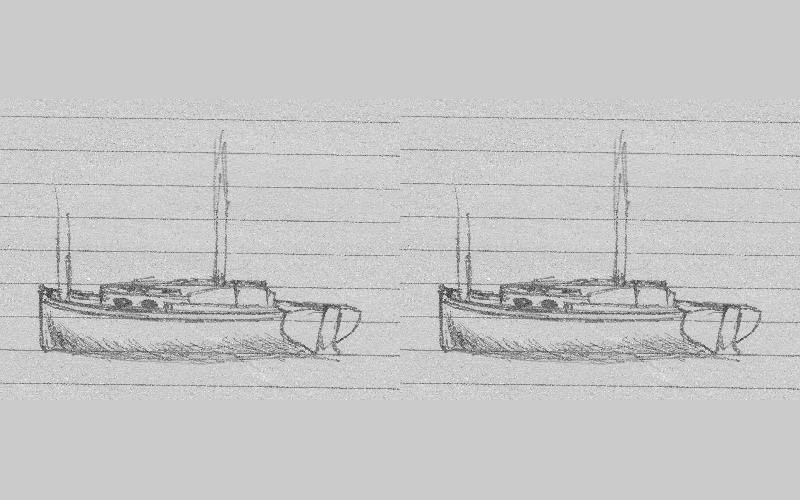

In [36]:
Image.fromarray(np.hstack([sketch_grey, new_image]))